<a href="https://colab.research.google.com/github/Jarukit-Jack/project_deep_learningvv/blob/main/deep_learn_eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Ethereum (ETH-USD) Price using LSTM


This notebook build and train an LSTM (Long Short-Term Memory) model to forecast the price of Ethereum (ETH-USD).

**Steps:**
1. StepA: Download Dependencies
2. StepB: Data Preparation
3. StepC: Design Model
4. StepD: Model Setup
5. StepE: Model Training
6. StepF: Model Evaluation


# StepA :Download Dependencies

In [33]:
%%capture
# !pip install d2l==1.0.3
!pip install yfinance
# !pip install torch==1.13.1
# !pip install matplotlib
!pip install tqdm==4.67.1
!pip install torchvision
# !pip install functools0
!pip install torchsummary
from torchsummary import summary
import yfinance as yf
import os
import random
import IPython
# import functools0
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# import pandas
import pandas as pd

# import type
from typing import Union, List

# d2l lib for learning
# from d2l import torch as d2l

# select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# StepB: Prepare Data


1.  **Fetching Data:** The `fetch_data` function uses the `yfinance` The `period="max"` argument ensures that all available historical data is downloaded.
2.  **Scaling Data:** The `prepare_data` function takes the raw data and scales it using `MinMaxScaler`.

3.  **Creating Sequences:** The scaled data is then transformed into sequences. The `sequence_length` parameter (set to 60 in this case) determines how many previous days' data are used to predict the price on the next day.

4.  **Splitting Data:** set to 0.8, meaning 80% for training and 20% for testing.

5.  **Converting to PyTorch Tensors:** Finally, the NumPy arrays for the training and testing sets (`X_train`, `y_train`, `X_test`, `y_test`) are converted into PyTorch tensors.

In [34]:
def fetch_data(symbol: Union[str, List[str]] = "ETH-USD",
               period: str = "max",
               interval: str = "1d",
               auto_adjust: bool = True) -> pd.DataFrame:

    # Download the data from Yahoo Finance
    df = yf.download(symbol, period=period, interval=interval, group_by='symbol')

    # Reset index
    df = df.reset_index()

    # Flatten columns - ใช้เฉพาะส่วนที่สอง (Price) หรือ Date
    new_columns = []
    for col in df.columns:
        if col[0] == 'Date' or col[1] == '':
            new_columns.append('Date')
        else:
            new_columns.append(col[1])  # เอาแค่ 'Open', 'High', 'Low', etc.

    df.columns = new_columns

    return df
data = fetch_data()
print(data)

/tmp/ipython-input-2159855453.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=period, interval=interval, group_by='symbol')
[*********************100%***********************]  1 of 1 completed

           Date         Open         High          Low        Close  \
0    2017-11-09   308.644989   329.451996   307.056000   320.884003   
1    2017-11-10   320.670990   324.717987   294.541992   299.252991   
2    2017-11-11   298.585999   319.453003   298.191986   314.681000   
3    2017-11-12   314.690002   319.153015   298.513000   307.907990   
4    2017-11-13   307.024994   328.415009   307.024994   316.716003   
...         ...          ...          ...          ...          ...   
2912 2025-10-30  3903.322510  3948.222656  3681.909424  3804.375244   
2913 2025-10-31  3805.082764  3900.580322  3797.669189  3847.080322   
2914 2025-11-01  3847.171387  3906.780273  3832.634766  3874.187988   
2915 2025-11-02  3873.894287  3914.875488  3839.997314  3911.063232   
2916 2025-11-03  3907.742920  3911.716309  3690.399658  3731.259521   

           Volume  
0       893249984  
1       885985984  
2       842300992  
3      1613479936  
4      1041889984  
...           ...  
2912  3

In [35]:
from typing import Union, List, Tuple
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# prepare data
def prepare_data(df: pd.DataFrame,
                 features=['Open','High','Low','Close','Volume'],
                 target='Close', sequence_length=60, train_split=0.8):

    data = df[features].values.astype(np.float32)
    target_data = df[target].values.reshape(-1, 1).astype(np.float32)

    N = len(df)
    n_samples = N - sequence_length
    train_len = int(n_samples * train_split)
    fit_end = sequence_length + train_len   # ครอบคลุมหน้าต่างล้าหลังของ train

    scaler_X = MinMaxScaler().fit(data[:fit_end])
    scaler_y = MinMaxScaler().fit(target_data[:fit_end])

    data_scaled = scaler_X.transform(data)
    target_scaled = scaler_y.transform(target_data)

    # ทำ sequences
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y.append(target_scaled[i])
    X = np.array(X); y = np.array(y)

    # แบ่งตามจำนวน sample
    X_train, X_test = X[:train_len], X[train_len:]
    y_train, y_test = y[:train_len], y[train_len:]

    # ไปยัง device
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    return X_train, y_train, X_test, y_test, scaler_X, scaler_y


In [36]:
# test fetch data from yahoo finance
symbol = ["ETH-USD"]
data = fetch_data(symbol)

/tmp/ipython-input-2159855453.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=period, interval=interval, group_by='symbol')
[*********************100%***********************]  1 of 1 completed


In [37]:
data

,Date,Open,High,Low,Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...,...
2912,2025-10-30,3903.322510,3948.222656,3681.909424,3804.375244,39981939289
2913,2025-10-31,3805.082764,3900.580322,3797.669189,3847.080322,37800100395
2914,2025-11-01,3847.171387,3906.780273,3832.634766,3874.187988,17490279524
2915,2025-11-02,3873.894287,3914.875488,3839.997314,3911.063232,20479611654


In [8]:
# _dntk.DeepnoteChart(data, """{"layer":[{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"Date","scale":{"type":"linear"},"timeUnit":"yearmonthdate","bandPosition":0},"y":{"axis":{"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Close","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"color":{"type":"nominal","datum":"Close","scale":{"range":["#2266D3"],"domain":["Close"]}},"xOffset":{"datum":"series_0"}},"transform":[]}]}],"resolve":{"scale":{"color":"independent"}}}],"title":"","config":{"legend":{"disable":false}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"seriesNames":["Close"],"seriesOrder":[0],"specSchemaVersion":2,"tooltipDefaultMode":true}}""", attach_selection=True, filters='[]')

In [39]:
print(data.columns)
print(data.size)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
17502


# StepC: Design Model

In [41]:
# ref: https://github.com/NimaVahdat/ETH_Price_Prediction/blob/main/Networks/networks.py
# implement recurrent nerual network and LSTM
class LSTM_model(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension, n_layers, dropout_rate):
        super(LSTM_model, self).__init__()

        # บันทึก parameters
        self.hidden_dimension = hidden_dimension
        self.n_layers = n_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dimension,
            hidden_dimension,
            n_layers,
            dropout=dropout_rate if n_layers > 1 else 0,
            batch_first=True,
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dimension, output_dimension)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # LSTM forward pass
        output, (hidden, cell) = self.lstm(x)

        # ใช้ hidden state ของ layer สุดท้าย
        hidden = self.dropout(hidden[-1])

        # Prediction
        prediction = self.fc(hidden)

        return prediction

# StepD: Model Setup

In [42]:

# setup hyper parameter
input_dimension = 5
hidden_dimension = 64
output_dimension = 1
n_layers = 2
dropout_rate = 0.3
max_epoch = 750
lr= 0.00001
batch_size = 256

# define model
model = LSTM_model(input_dimension=input_dimension,hidden_dimension=hidden_dimension,
output_dimension=output_dimension, n_layers = n_layers, dropout_rate= dropout_rate
).to(device)

# load data
df = fetch_data(period="max")
X_train, y_train, X_test, y_test, scaler_X, scaler_y = prepare_data(
    df,
    sequence_length=60,
    train_split=0.8
)
train_n = int(len(X_train) * 0.8) if len(X_train) > 1 else len(X_train)
print(f"total data = {train_n}")
# training_data
X_tr = X_train[:train_n].cpu()
y_tr = y_train[:train_n].cpu()
# valide
X_val = X_train[train_n:].cpu() if train_n < len(X_train) else X_train[:0].cpu()
y_val = y_train[train_n:].cpu() if train_n < len(y_train) else y_train[:0].cpu()

# define train dataset
train_ds = TensorDataset(X_tr, y_tr)
# define test dataset
val_ds = TensorDataset(X_val, y_val) if len(X_val) > 0 else None

# define train to model
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
# test dataset
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) if val_ds is not None else None

# define loss function
loss_fn = torch.nn.MSELoss()
otm = torch.optim.Adam(model.parameters(), lr=lr)


/tmp/ipython-input-2159855453.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=period, interval=interval, group_by='symbol')
[*********************100%***********************]  1 of 1 completed

total data = 1828


### Model Architecture


In [43]:
print("Model Architecture (Parameters):")
print("-" * 30)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}, Shape: {param.data.shape}")
print("-" * 30)

# You can also print the model summary directly, which might provide some structural information
print("\nModel Summary:")
print("-" * 30)
print(model)
print("-" * 30)

Model Architecture (Parameters):
------------------------------
Layer: lstm.weight_ih_l0, Shape: torch.Size([256, 5])
Layer: lstm.weight_hh_l0, Shape: torch.Size([256, 64])
Layer: lstm.bias_ih_l0, Shape: torch.Size([256])
Layer: lstm.bias_hh_l0, Shape: torch.Size([256])
Layer: lstm.weight_ih_l1, Shape: torch.Size([256, 64])
Layer: lstm.weight_hh_l1, Shape: torch.Size([256, 64])
Layer: lstm.bias_ih_l1, Shape: torch.Size([256])
Layer: lstm.bias_hh_l1, Shape: torch.Size([256])
Layer: fc.weight, Shape: torch.Size([1, 64])
Layer: fc.bias, Shape: torch.Size([1])
------------------------------

Model Summary:
------------------------------
LSTM_model(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
------------------------------


In [44]:
# ติดตั้ง torchviz สำหรับวาด graph
%%capture
!pip install torchviz

import torch
import torch.nn as nn
from torchviz import make_dot

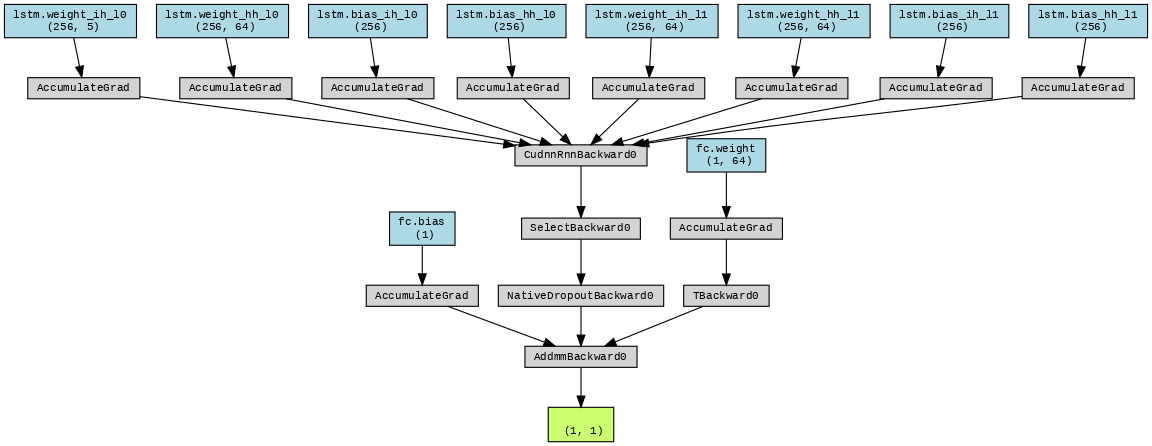

In [45]:
# Use a sample from the actual training data
if len(X_train) > 0:
  x = X_train[0].unsqueeze(0).to(device) # Add batch dimension and move to device
else:
  # Fallback to dummy input if training data is empty (shouldn't happen with fetch_data)
  x = torch.randn(1, 60, input_dimension).to(device)

y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))

dot.format = 'png'
dot.render('LSTM_model_architecture')
from IPython.display import Image
Image(filename='LSTM_model_architecture.png')

# StepE: Model Training

In [46]:
# Training Loop
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(max_epoch):
    # ========== Training ==========
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)
        loss_value = loss_fn(y_pred, y_batch)

        # Backward pass
        otm.zero_grad()
        loss_value.backward()
        otm.step()

        train_loss += loss_value.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ========== Validation ==========
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss_value = loss_fn(y_pred, y_batch)
            val_loss += loss_value.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{max_epoch}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print(f'\nTraining completed! Best Val Loss: {best_val_loss:.6f}')

# Load best model
model.load_state_dict(torch.load('best_lstm_model.pth'))

Epoch [5/750] - Train Loss: 0.077461, Val Loss: 0.132668
Epoch [10/750] - Train Loss: 0.076438, Val Loss: 0.128385
Epoch [15/750] - Train Loss: 0.073626, Val Loss: 0.124294
Epoch [20/750] - Train Loss: 0.072338, Val Loss: 0.120349
Epoch [25/750] - Train Loss: 0.071108, Val Loss: 0.116563
Epoch [30/750] - Train Loss: 0.069176, Val Loss: 0.112895
Epoch [35/750] - Train Loss: 0.068063, Val Loss: 0.109324
Epoch [40/750] - Train Loss: 0.066921, Val Loss: 0.105857
Epoch [45/750] - Train Loss: 0.065391, Val Loss: 0.102505
Epoch [50/750] - Train Loss: 0.064065, Val Loss: 0.099224
Epoch [55/750] - Train Loss: 0.063191, Val Loss: 0.096037
Epoch [60/750] - Train Loss: 0.061230, Val Loss: 0.092914
Epoch [65/750] - Train Loss: 0.060581, Val Loss: 0.089871
Epoch [70/750] - Train Loss: 0.059467, Val Loss: 0.086922
Epoch [75/750] - Train Loss: 0.058288, Val Loss: 0.084038
Epoch [80/750] - Train Loss: 0.056984, Val Loss: 0.081202
Epoch [85/750] - Train Loss: 0.056079, Val Loss: 0.078463
Epoch [90/750] 

<All keys matched successfully>

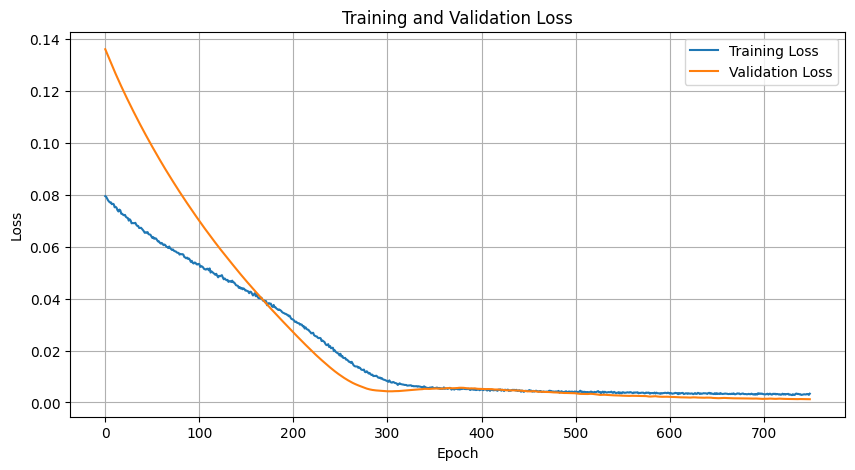

In [47]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# StepF: Model Evaluation

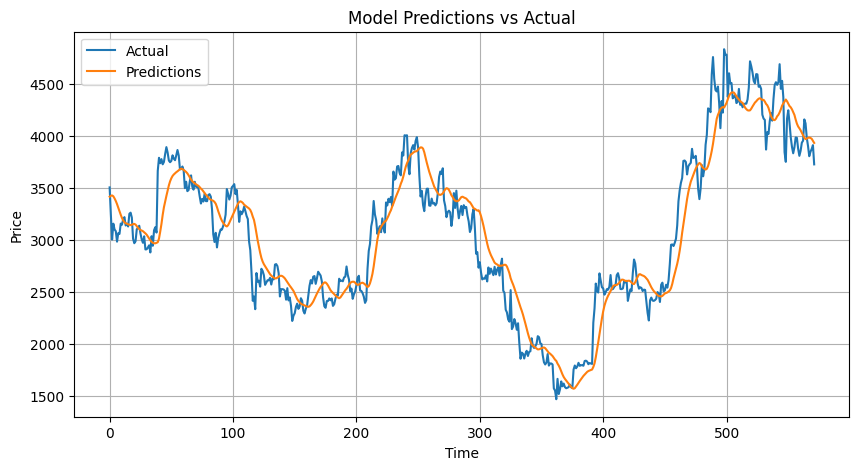

In [48]:
# Evaluate the model on the test set
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for i in range(len(X_test)):
        X_sample = X_test[i].unsqueeze(0)  # Add batch dimension
        y_sample = y_test[i]
        y_pred = model(X_sample)
        predictions.append(y_pred.cpu().numpy())
        actual.append(y_sample.cpu().numpy())

predictions = np.array(predictions).reshape(-1, 1)
actual = np.array(actual).reshape(-1, 1)

# Inverse transform to get actual values
predictions = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(actual)

# Plot predictions vs actual
plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()

📊 ETH-USD Price Prediction Results
Total data points: 2,917 days
Training data: 2,285 days
Testing data: 572 days

📈 Model Accuracy:
RMSE: $245.24
MAE:  $186.25
MAPE: 6.31%

📋 Prediction Examples (First 10 days of Test Set):
----------------------------------------------------------------------
Index    Actual Price    Predicted Price Difference     
----------------------------------------------------------------------
1        $    3,505.25 $    3,416.20 $       89.05
2        $    3,243.03 $    3,424.58 $     -181.55
3        $    3,004.90 $    3,428.35 $     -423.45
4        $    3,156.94 $    3,419.99 $     -263.05
5        $    3,101.60 $    3,399.41 $     -297.81
6        $    3,084.92 $    3,374.71 $     -289.79
7        $    2,984.73 $    3,344.90 $     -360.17
8        $    3,066.03 $    3,310.57 $     -244.54
9        $    3,059.28 $    3,274.27 $     -214.99
10       $    3,157.63 $    3,242.72 $      -85.10
------------------------------------------------------------------

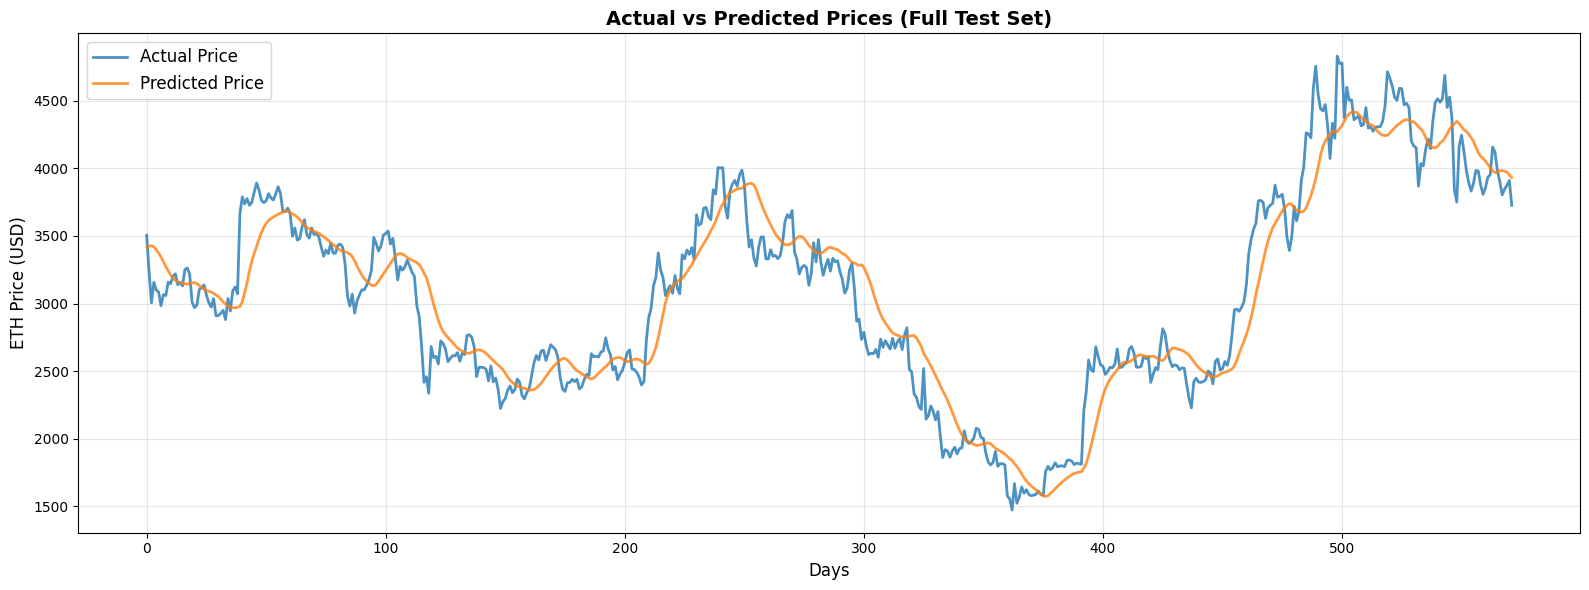

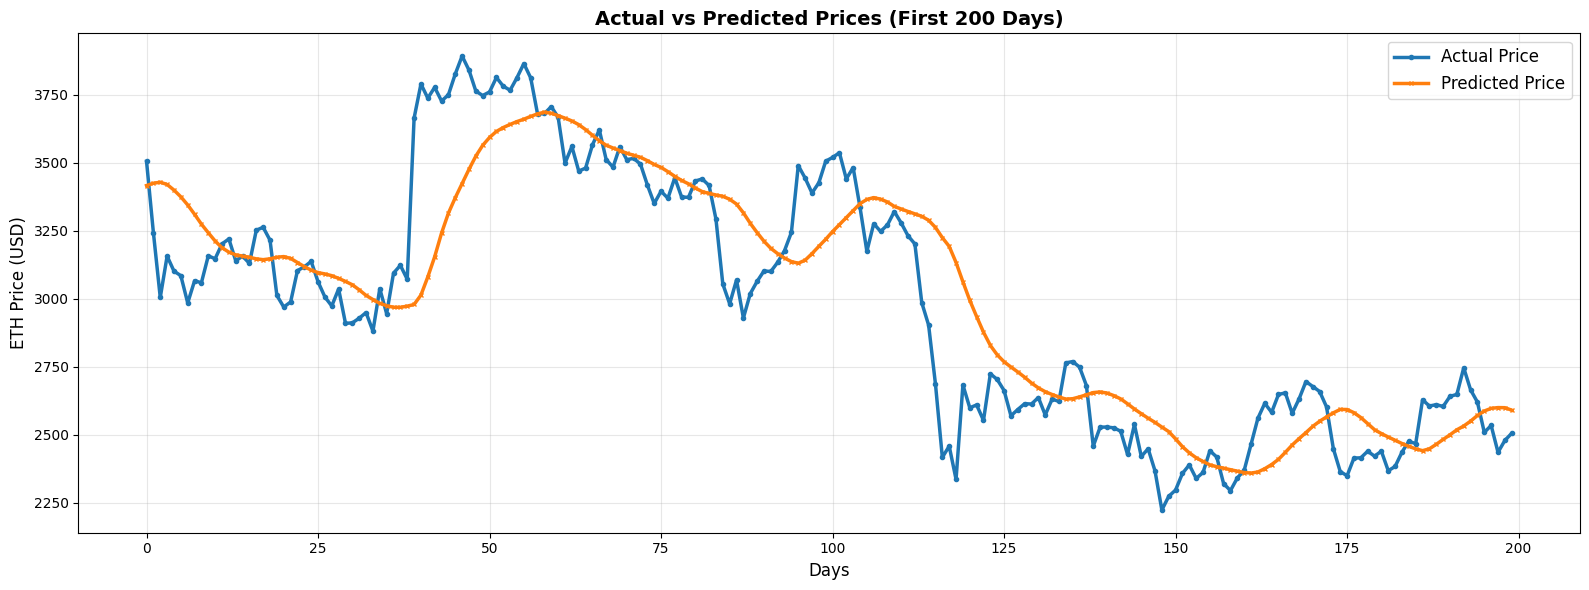

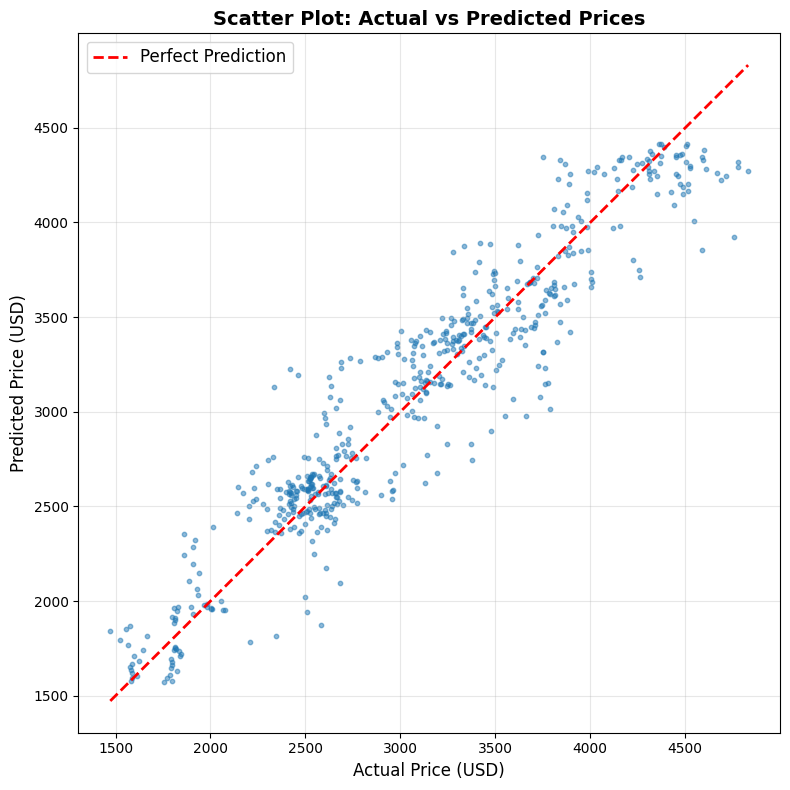

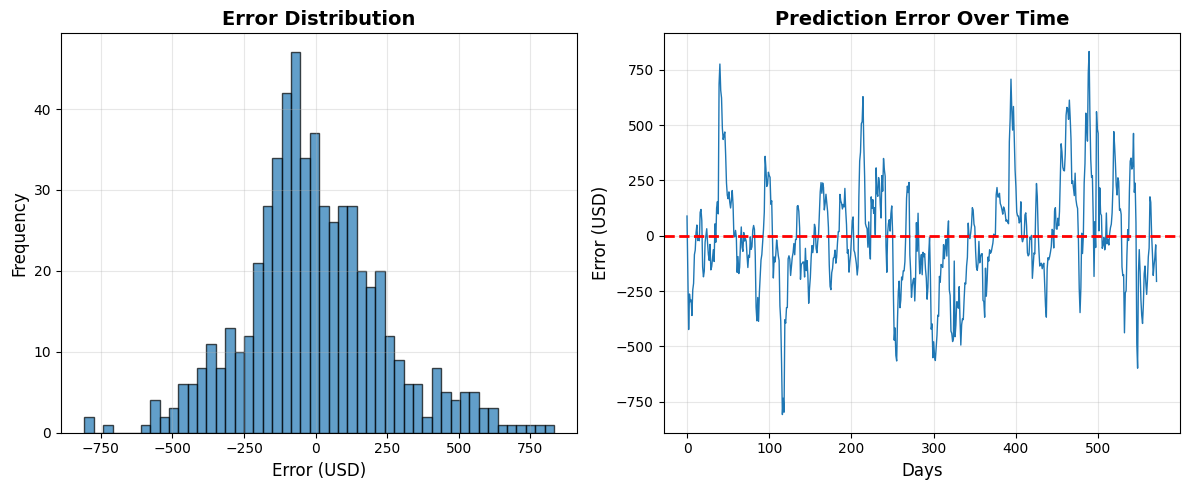

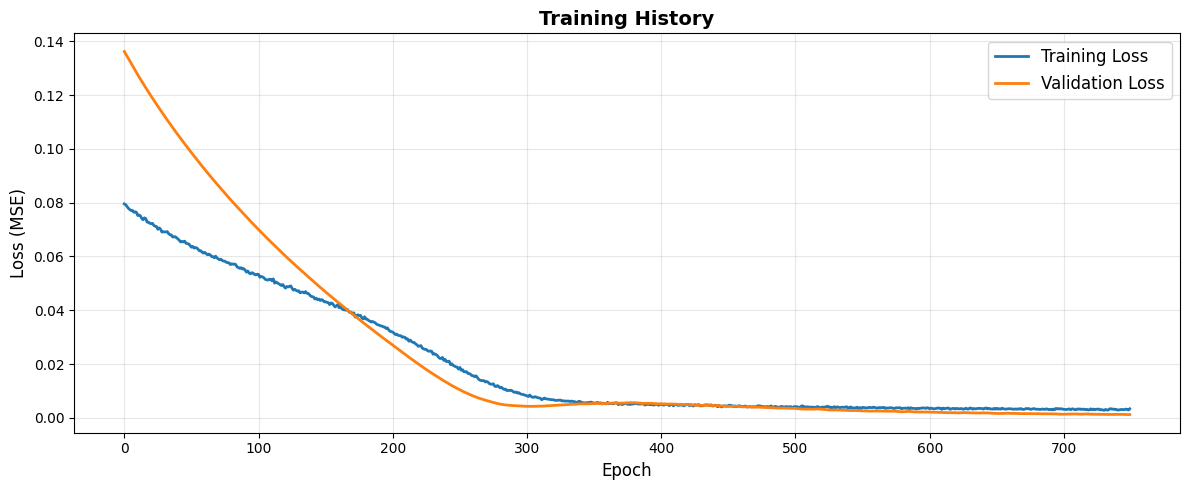


✅ Done! Model successfully predicted ETH prices


In [49]:
# ==================== Predict Future Prices ====================

# 1. Predict on test set
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test).cpu().numpy()
    y_test_scaled = y_test.cpu().numpy()

# 2. Inverse transform to get real prices
y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# 3. Print summary
print("="*70)
print("📊 ETH-USD Price Prediction Results")
print("="*70)
print(f"Total data points: {len(df):,} days")
print(f"Training data: {len(X_train):,} days")
print(f"Testing data: {len(X_test):,} days")

# 4. Calculate accuracy metrics
mse = np.mean((y_test_real - y_pred_real) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_real - y_pred_real))
mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100

print(f"\n📈 Model Accuracy:")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE:  ${mae:,.2f}")
print(f"MAPE: {mape:.2f}%")

# 5. Show prediction examples
print(f"\n📋 Prediction Examples (First 10 days of Test Set):")
print("-"*70)
print(f"{'Index':<8} {'Actual Price':<15} {'Predicted Price':<15} {'Difference':<15}")
print("-"*70)

for i in range(min(10, len(y_test_real))):
    real = y_test_real[i][0]
    pred = y_pred_real[i][0]
    diff = real - pred
    print(f"{i+1:<8} ${real:>12,.2f} ${pred:>12,.2f} ${diff:>12,.2f}")

print("-"*70)

# 6. Show last 10 days
print(f"\n📌 Last 10 Days Predictions:")
print("-"*70)
print(f"{'Index':<8} {'Actual Price':<15} {'Predicted Price':<15} {'Difference':<15}")
print("-"*70)

for i in range(max(0, len(y_test_real)-10), len(y_test_real)):
    real = y_test_real[i][0]
    pred = y_pred_real[i][0]
    diff = real - pred
    idx = i - (len(y_test_real) - 10)
    print(f"{idx+1:<8} ${real:>12,.2f} ${pred:>12,.2f} ${diff:>12,.2f}")

print("="*70)

# ==================== Plot Graphs ====================

# Graph 1: Compare Actual vs Predicted (All data)
plt.figure(figsize=(16, 6))
plt.plot(y_test_real, label='Actual Price', linewidth=2, alpha=0.8)
plt.plot(y_pred_real, label='Predicted Price', linewidth=2, alpha=0.8)
plt.xlabel('Days', fontsize=12)
plt.ylabel('ETH Price (USD)', fontsize=12)
plt.title('Actual vs Predicted Prices (Full Test Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graph 2: Zoom into first 200 days
plt.figure(figsize=(16, 6))
n_show = min(200, len(y_test_real))
plt.plot(y_test_real[:n_show], label='Actual Price', linewidth=2.5, marker='o', markersize=3)
plt.plot(y_pred_real[:n_show], label='Predicted Price', linewidth=2.5, marker='x', markersize=3)
plt.xlabel('Days', fontsize=12)
plt.ylabel('ETH Price (USD)', fontsize=12)
plt.title(f'Actual vs Predicted Prices (First {n_show} Days)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graph 3: Scatter plot (Actual vs Predicted)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_real, y_pred_real, alpha=0.5, s=10)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Price (USD)', fontsize=12)
plt.ylabel('Predicted Price (USD)', fontsize=12)
plt.title('Scatter Plot: Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graph 4: Error Distribution
errors = y_test_real.flatten() - y_pred_real.flatten()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Error (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Error Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(errors, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Error (USD)', fontsize=12)
plt.title('Prediction Error Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Graph 5: Training History
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Done! Model successfully predicted ETH prices")

The training and validation loss plot shows the model's performance over epochs, and the predictions vs actual plot illustrates how well the model's predictions align with the actual values.

In [51]:
# Import libraries ที่จำเป็นสำหรับการประเมินผลเพิ่มเติม
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
import numpy as np

# --- 1. Mean Squared Error (MSE) ---
mse = mean_squared_error(y_test_real, y_pred_real)
print(f"Mean Squared Error (MSE):     {mse:,.2f}")

# --- 2. Median Absolute Error (MedAE) ---
medae = median_absolute_error(y_test_real, y_pred_real)
print(f"Median Absolute Error (MedAE):  ${medae:,.2f}")

# --- 3. R-squared (R²) ---
# (วัดว่าโมเดลอธิบายความผันผวนได้ดีแค่ไหน)
r2 = r2_score(y_test_real, y_pred_real)
print(f"R-squared (R²):               {r2:.4f}")

# --- 4. Correlation Coefficient (Pearson’s r) ---
# (วัดทิศทาง)
y_true_flat = y_test_real.flatten()
y_pred_flat = y_pred_real.flatten()
correlation = np.corrcoef(y_true_flat, y_pred_flat)[0, 1]
print(f"Correlation (Pearson's r):  {correlation:.4f}")


# --- 5. Symmetric Mean Absolute Percentage Error (sMAPE) ---
# (MAPE ที่สมมาตรกว่า)
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

smape_val = smape(y_true_flat, y_pred_flat)
print(f"sMAPE:                        {smape_val:.2f}%")


# --- 6. Directional Accuracy (DA) ---
# (วัดความแม่นยำในการทายทิศทาง ขึ้น/ลง)
# เราต้องเปรียบเทียบผลต่างของวันนี้กับเมื่อวาน (ใช้ np.diff)
y_true_diff = np.diff(y_true_flat)
y_pred_diff = np.diff(y_pred_flat)

# หาเครื่องหมาย (+ หรือ -) ของผลต่าง
y_true_sign = np.sign(y_true_diff)
y_pred_sign = np.sign(y_pred_diff)

# DA คือ เปอร์เซ็นต์ที่เครื่องหมายตรงกัน
da = np.mean(y_true_sign == y_pred_sign) * 100
print(f"Directional Accuracy (DA):    {da:.2f}%")

Mean Squared Error (MSE):     60,141.61
Median Absolute Error (MedAE):  $137.87
R-squared (R²):               0.8968
Correlation (Pearson's r):  0.9471
sMAPE:                        6.26%
Directional Accuracy (DA):    46.58%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c77ad26d-d81f-4109-ae7f-7b27fc6fbdbc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>